In [ ]:
# dependencies
import os
import keras
import tensorflow as tf
from keras import Model
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from shutil import copy
import random
from keras.utils import load_img, img_to_array
from tensorflow import expand_dims
import tensorflow_datasets as tfds



Data Extraction

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete4P8QUM/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
#Get the class name from the tensorflow dataset
class_name = info.features['label'].names


In [ ]:
#make different folder for cat and dog images
for i, data in enumerate(dataset['train']):
  image, label = data

  path = f'cats_vs_dog/train/{class_name[label]}'
  os.makedirs(path, exist_ok=True)

  filename = path + f'/{class_name[label]}_{i}.jpg'
  keras.preprocessing.image.save_img(filename, image)


Model building

In [ ]:
# this model is based on the Keras Classification tutorial which uses a XCeption architecture
# with some modification:
# adding a middle block
# adding a conv2d in the Exit block with the previous block for the residual

# entry_block

image_shape = (180,180,3,)

input = layers.Input(shape= image_shape)
x = layers.Conv2D(64,3, strides= 2, padding='same')(input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(128,3, strides= 2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

previous_block = x

# increasing the filter to recongnize more precise paterns
for filters in [256,512,728]:

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(filters,3, padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(filters,3, padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

  # model residual
  residual = layers.Conv2D(filters,1, strides=2, padding='same')(previous_block)

  previous_block = x


# middle block
# 8 layers of two Separable conv3d of 728 filters (3x3)
# activation before each separableCon2d to remove the linearity of the model
# batch normalization to improve generalization and make the training faster and more stable
# no MaxPolling in these layers

for i in range(8) :
  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(728,3, padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.Activation('relu')(x)
  x = layers.SeparableConv2D(728,3, padding='same')(x)
  x = layers.BatchNormalization()(x)

previous_block = x


# Exit block
# add the residual layer and another Separable conv of 1020 params before the activation

x = layers.SeparableConv2D(1024,3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

residual = layers.Conv2D(1024,3, padding='same')(previous_block)
x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.6)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(input, output)







In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 90, 90, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 90, 90, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 90, 90, 64)           0         ['batch_normalization[0][0

Model compiling

In [ ]:
model.compile(
    optimizer = 'adam',
    loss="binary_crossentropy",
    metrics=["accuracy"],
    )

Data preprocessing

In [ ]:
data_gen = ImageDataGenerator(rescale=1.0 / 255.0, width_shift_range=0.25, height_shift_range= 0.25,
                                         rotation_range=25,
                                         zoom_range=0.25,validation_split=0.2, horizontal_flip=True)

path = 'content/cats_vs_dog/train'

train_generator = data_gen.flow_from_directory(
        path, target_size=(180, 180),
        batch_size=128,
        class_mode='binary',
        subset='training')


validation_generator = data_gen.flow_from_directory(
        path,
        subset='validation',
        target_size=(180, 180),
        batch_size=128,
        class_mode='binary'
    )

Found 18611 images belonging to 2 classes.
Found 4651 images belonging to 2 classes.


Fit model

In [ ]:
history = model.fit(
        train_generator,
        epochs=50,
        steps_per_epoch=len(train_generator),
        validation_steps=len(validation_generator),
        validation_data=validation_generator,
        verbose=1,
        use_multiprocessing=True,
        workers=16,
    )



Epoch 1/50
146/146 [==============================] - 106s 548ms/step - loss: 0.6712 - accuracy: 0.6298 - val_loss: 0.6934 - val_accuracy: 0.5012
Epoch 2/50
146/146 [==============================] - 80s 515ms/step - loss: 0.5608 - accuracy: 0.7062 - val_loss: 0.6937 - val_accuracy: 0.4988
Epoch 3/50
146/146 [==============================] - 80s 509ms/step - loss: 0.5006 - accuracy: 0.7569 - val_loss: 0.6931 - val_accuracy: 0.5012
Epoch 4/50
146/146 [==============================] - 78s 505ms/step - loss: 0.4356 - accuracy: 0.8014 - val_loss: 0.6934 - val_accuracy: 0.4988
Epoch 5/50
146/146 [==============================] - 75s 485ms/step - loss: 0.3751 - accuracy: 0.8310 - val_loss: 0.6662 - val_accuracy: 0.5235
Epoch 6/50
146/146 [==============================] - 77s 502ms/step - loss: 0.3340 - accuracy: 0.8513 - val_loss: 0.5586 - val_accuracy: 0.7102
Epoch 7/50
146/146 [==============================] - 78s 502ms/step - loss: 0.3017 - accuracy: 0.8705 - val_loss: 0.4549 - val_a

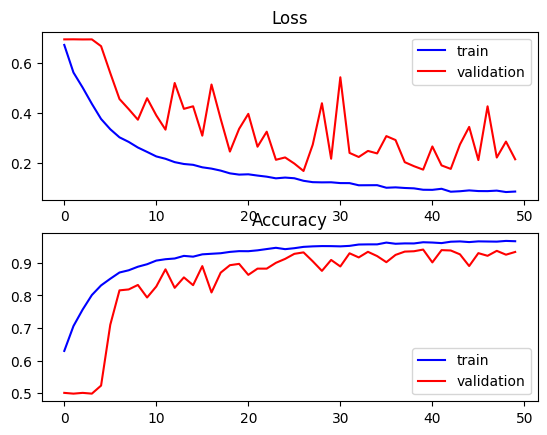

In [ ]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='validation')
plt.legend()
plt.subplot(212)
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='validation')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
%cd /content/drive/MyDrive/Cat_vs_dog/
%ls

[Errno 2] No such file or directory: '/content/drive/MyDrive/Cat_vs_dog/'
/content
sample_data/


In [ ]:
model.save('XCeption50E.h5')

In [ ]:
#save the model on the drive
%cd /content/drive/MyDrive/Cat_vs_dog/
%ls
model = keras.models.load_model('XCeption50E.h5')


/content/drive/MyDrive/Cat_vs_dog
Cat_dog_data/    Cat_dog_data_2.zip  cats_vs_dog/  test_set/      XCeption50E.h5
Cat_dog_data_2/  Cat_dog_data.zip    model.h5      training_set/  XCeption.h5


Cat_dog_data/test/9773.jpg
1/1 [==============================] - 9s 9s/step
dog: 0.0%, cat: 100.0%


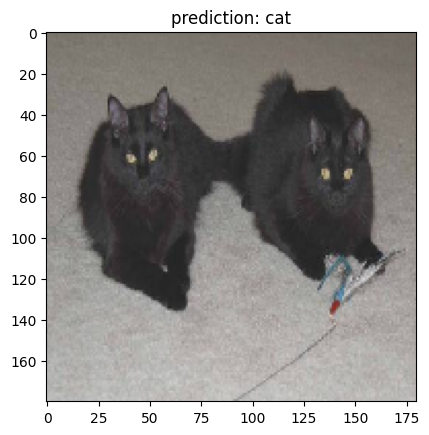

Cat_dog_data/test/9850.jpg
1/1 [==============================] - 0s 22ms/step
dog: 100.0%, cat: 0.0%


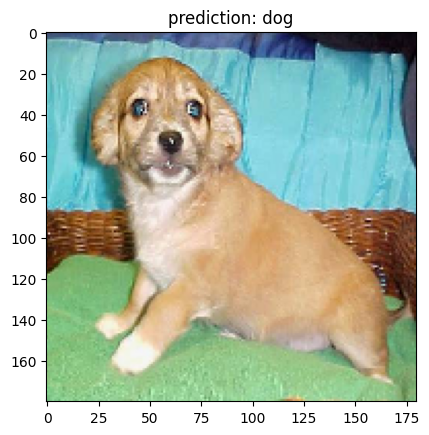

Cat_dog_data/test/9820.jpg
1/1 [==============================] - 0s 22ms/step
dog: 0.0%, cat: 100.0%


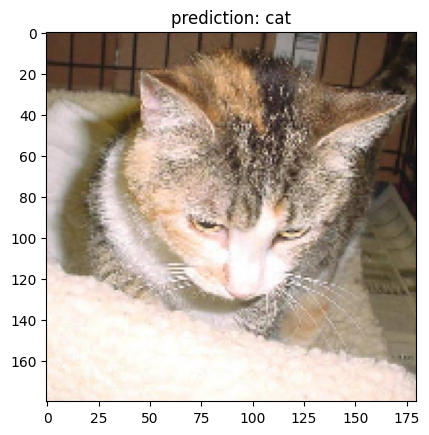

Cat_dog_data/test/9805.jpg
1/1 [==============================] - 0s 25ms/step
dog: 0.0%, cat: 100.0%


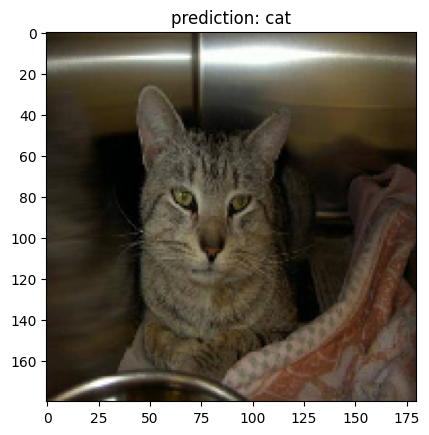

Cat_dog_data/test/9691.jpg
1/1 [==============================] - 0s 23ms/step
dog: 13.21%, cat: 86.79%


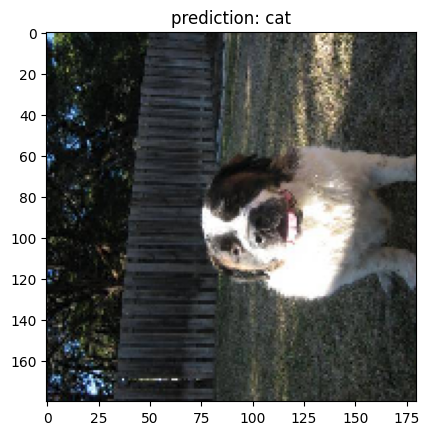

Cat_dog_data/test/9768.jpg
1/1 [==============================] - 0s 26ms/step
dog: 100.0%, cat: 0.0%


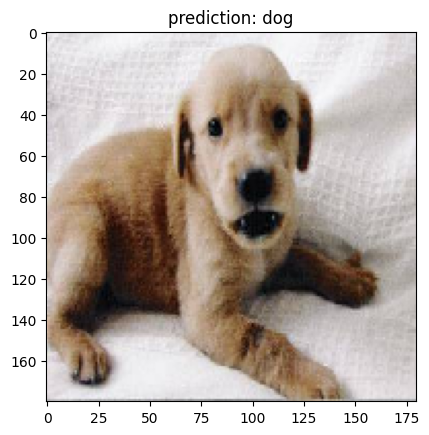

Cat_dog_data/test/Copie de 9686.jpg
1/1 [==============================] - 0s 25ms/step
dog: 100.0%, cat: 0.0%


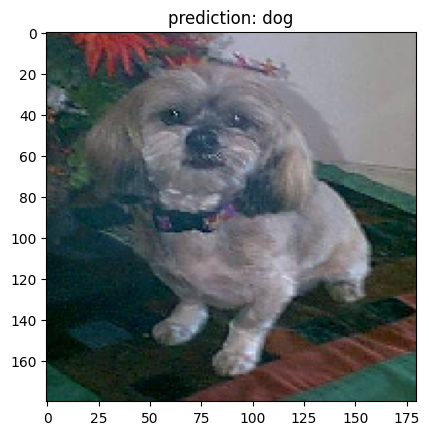

Cat_dog_data/test/Copie de 9724.jpg
1/1 [==============================] - 0s 23ms/step
dog: 17.66%, cat: 82.34%


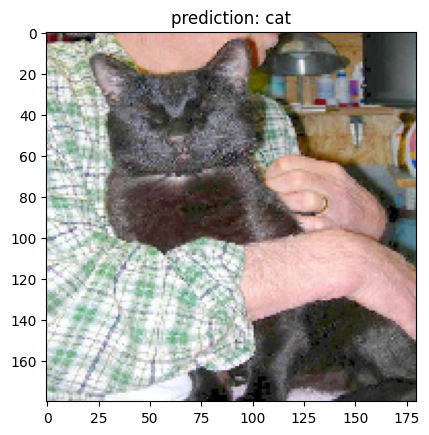

Cat_dog_data/test/9894.jpg
1/1 [==============================] - 0s 22ms/step
dog: 0.0%, cat: 100.0%


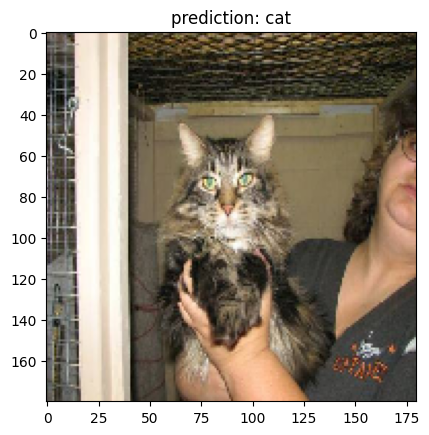

Cat_dog_data/test/Copie de 9678.jpg
1/1 [==============================] - 0s 22ms/step
dog: 100.0%, cat: 0.0%


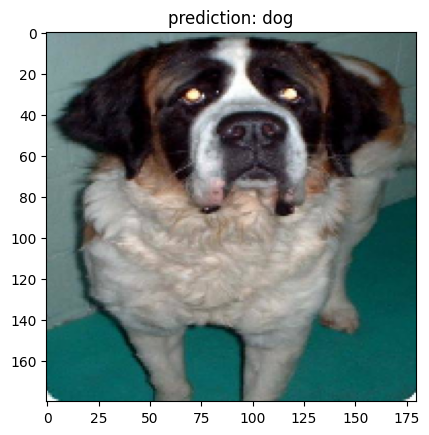

Cat_dog_data/test/9737.jpg
1/1 [==============================] - 0s 22ms/step
dog: 0.0%, cat: 100.0%


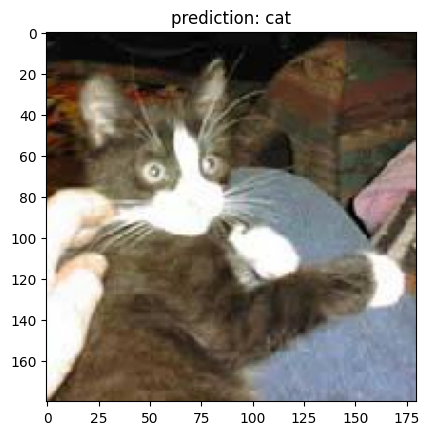

Cat_dog_data/test/Copie de 9736.jpg
1/1 [==============================] - 0s 23ms/step
dog: 0.57%, cat: 99.43%


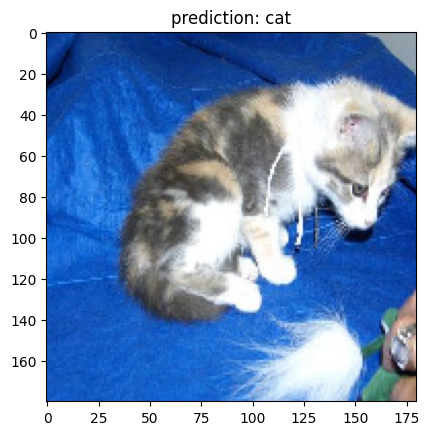

Cat_dog_data/test/9843.jpg
1/1 [==============================] - 0s 24ms/step
dog: 100.0%, cat: 0.0%


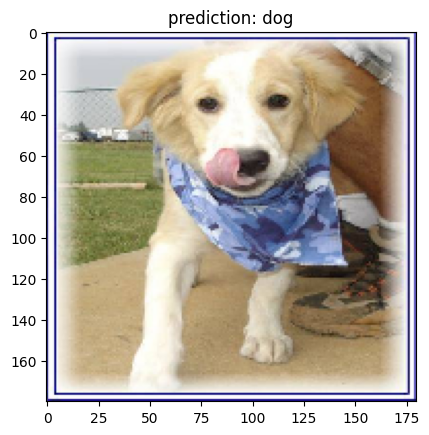

Cat_dog_data/test/9776.jpg
1/1 [==============================] - 0s 23ms/step
dog: 86.19%, cat: 13.81%


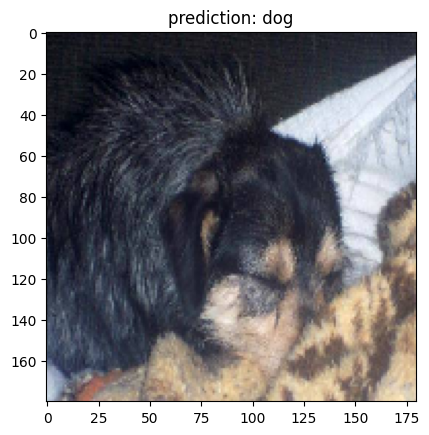

Cat_dog_data/test/9869.jpg
1/1 [==============================] - 0s 22ms/step
dog: 100.0%, cat: 0.0%


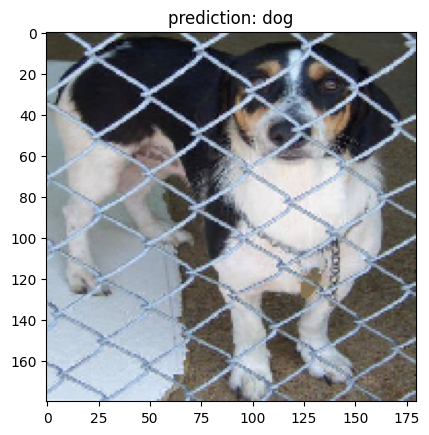

Cat_dog_data/test/Copie de 975.jpg
1/1 [==============================] - 0s 26ms/step
dog: 0.0%, cat: 100.0%


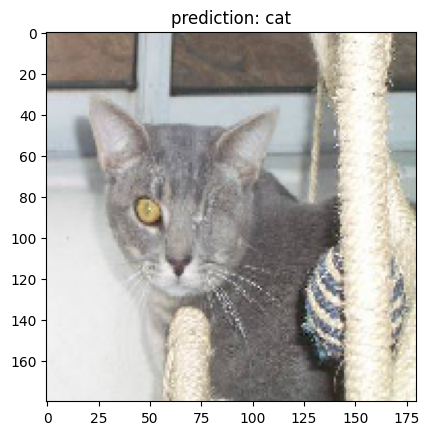

Cat_dog_data/test/9737.jpg
1/1 [==============================] - 0s 21ms/step
dog: 0.0%, cat: 100.0%


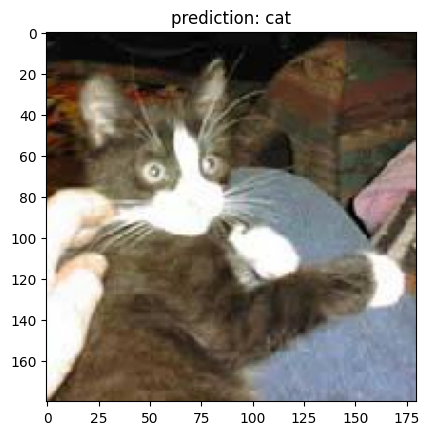

Cat_dog_data/test/9736.jpg
1/1 [==============================] - 0s 21ms/step
dog: 0.57%, cat: 99.43%


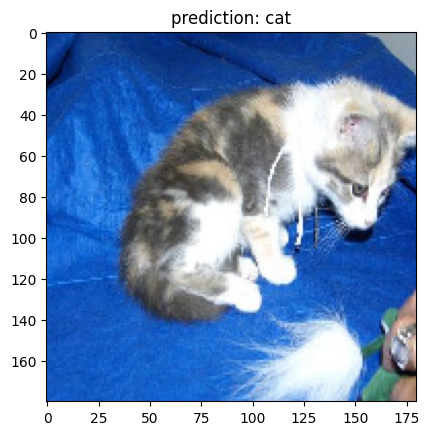

Cat_dog_data/test/9869.jpg
1/1 [==============================] - 0s 24ms/step
dog: 100.0%, cat: 0.0%


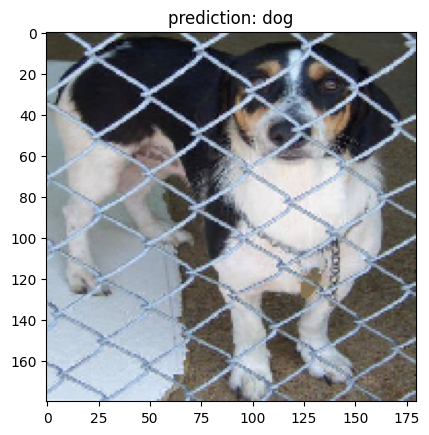

Cat_dog_data/test/9747.jpg
1/1 [==============================] - 0s 23ms/step
dog: 100.0%, cat: 0.0%


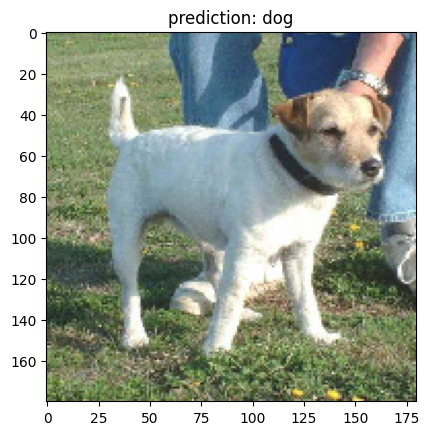

In [ ]:
#test on data never seen before

subpath = 'Cat_dog_data/test/'


#test on 50 ramdom images on the test datas
for i in range(20):
    path = subpath + random.choice(os.listdir(subpath))
    print(path)
    image = keras.preprocessing.image.load_img(path, target_size=(180,180,3))
    plt.imshow(image)
    image = keras.preprocessing.image.img_to_array(image)
    image = expand_dims(image,0)
    image = image/255.0

    prediction = model.predict(image)

    # set the threshold on 0.5 for dog and cat (50%)
    animal = 'dog'
    if prediction < 0.5:
        animal = 'cat'

    print(f'dog: {(prediction[0][0] * 100).round(2)}%, cat: {((1-prediction[0][0])*100).round(2)}%')



    plt.title(f'prediction: {animal}')
    plt.show()

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)